In [1]:
#!/usr/bin/env python3

# Loading data
import os
import time
import netCDF4
import h5py
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman" 
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'font.style': 'oblique'})

datapath = os.getcwd() + "/Data/data.txt"
# data = h5py.File(datapath, 'r')
data = np.loadtxt(datapath, delimiter = ", ")

ind_data_start = 2000
timestamp = data[ind_data_start:, 0]
lat = data[ind_data_start:, 1]
lon = data[ind_data_start:, 2]
x = data[ind_data_start:, 3]
y = data[ind_data_start:, 4]
z = data[ind_data_start:, 5]
d = data[ind_data_start:, 6]
sal = data[ind_data_start:, 7]
temp = data[ind_data_start:, 8]
lat_origin = data[ind_data_start:, 9]
lon_origin = data[ind_data_start:, 10]



In [2]:
circumference = 40075000 

def deg2rad(deg):
    return deg / 180 * np.pi 

def rad2deg(rad):
    return rad / np.pi * 180

def latlon2xy(lat, lon, lat_origin, lon_origin):
    x = deg2rad(lat - lat_origin) / 2 / np.pi * circumference
    y = deg2rad(lon - lon_origin) / 2 / np.pi * circumference * np.cos(deg2rad(lat))
    return x, y




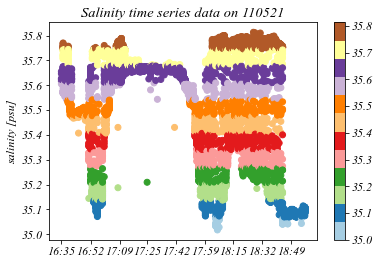

In [3]:
# Visualise the data in 3D environment
import plotly.graph_objects as go
import plotly

ind = np.where(sal >= 35)[0]

fig = go.Figure(data = [go.Scatter3d(
    x = lon[ind].squeeze(), 
    y = lat[ind].squeeze(), 
    z = z[ind].squeeze(), 
    mode = "markers", 
    marker = dict(
        size = 5, 
        color = sal[ind].squeeze(),
        showscale = True, 
        coloraxis = "coloraxis"
    )
)])
fig.update_coloraxes(colorscale = "jet")
fig.show()

# time series data
tid = []
for i in range(len(ind)):
    tid.append(datetime.fromtimestamp(timestamp[i]).strftime("%H:%M"))
plt.scatter(tid, sal[ind], c = sal[ind], vmin = 35, cmap = "Paired")
plt.colorbar()
plt.xticks(tid[0:len(tid):1000])
plt.ylabel("salinity [psu]")
plt.title("Salinity time series data on " + datetime.fromtimestamp(timestamp[i]).strftime("%m%d%y"))
plt.show()


2
-2


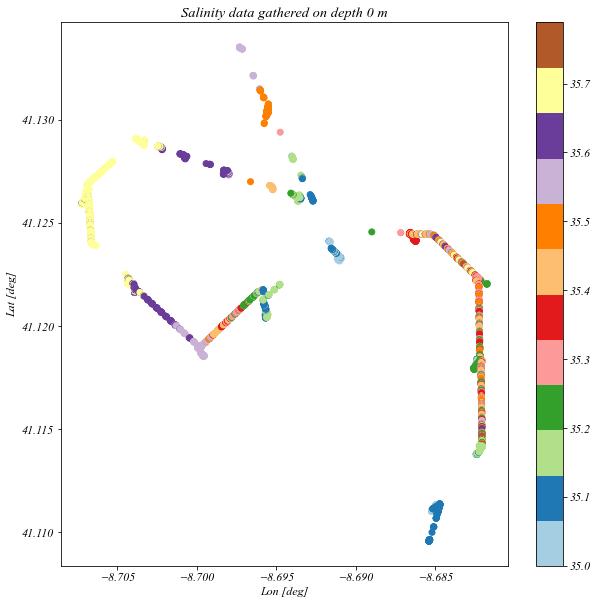

Time consumed:  7.386470079421997


/usr/local/lib/python3.9/site-packages/scikit_gstat-0.5.4-py3.9.egg/skgstat/plotting/variogram_plot.py:96: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   2847.74
Sill:              0.11
Nugget:            0.01
        
4.5
0.5


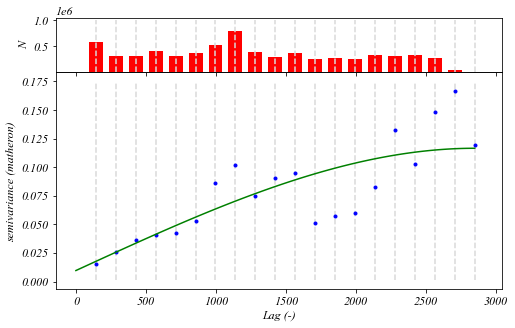

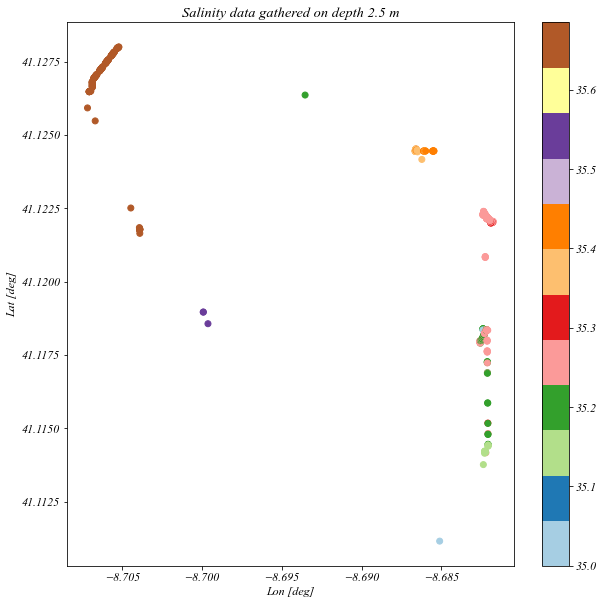

Time consumed:  0.09074997901916504
spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   2528.18
Sill:              0.07
Nugget:            0.04
        
7
3


/usr/local/lib/python3.9/site-packages/scikit_gstat-0.5.4-py3.9.egg/skgstat/plotting/variogram_plot.py:96: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



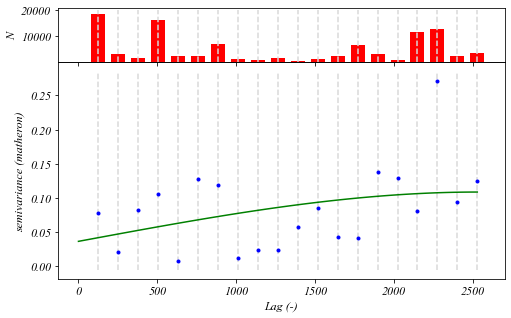

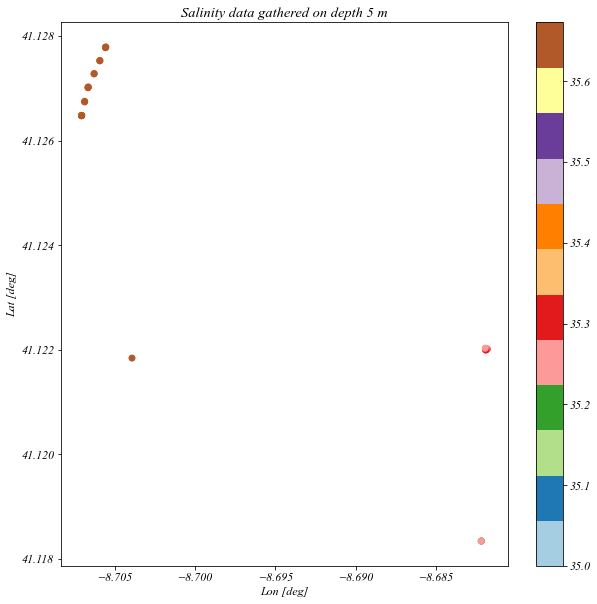

Time consumed:  0.034334421157836914
spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   2276.65
Sill:              0.07
Nugget:            0.00
        


/usr/local/lib/python3.9/site-packages/scikit_gstat-0.5.4-py3.9.egg/skgstat/plotting/variogram_plot.py:96: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



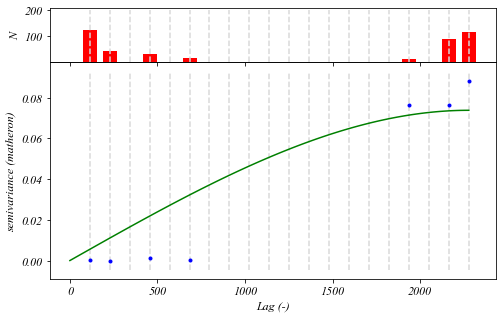

In [4]:
# Variogram for each layer
# Find the variogram    
from skgstat import Variogram 
    
def RoundBase(number, base = .5):
    # return rounded number
    nearest_multiple = base * np.round(number/base) 
    return nearest_multiple

def allocateLateral(lat, lon, z, sal, depth, tolerance):
    print(depth + tolerance)
    print(depth - tolerance)
    ind_depth = np.where((z <= depth + tolerance) & (z >= depth - tolerance))[0] 
    lat_depth = lat[ind_depth]
    lon_depth = lon[ind_depth]
    sal_depth = sal[ind_depth]
    return lat_depth, lon_depth, sal_depth 

depth_obs = [0, 2.5, 5]

for depth in depth_obs:
    lat_s, lon_s, sal_s = allocateLateral(lat, lon, z, sal, depth, 2)
    plt.figure(figsize = (10, 10))
    plt.scatter(lon_s, lat_s, c = sal_s, cmap = "Paired", vmin = 35) 
    plt.xlabel("Lon [deg]")
    plt.ylabel("Lat [deg]")
    plt.title("Salinity data gathered on depth " + str(depth) + " m")
    plt.colorbar()
    plt.show()
    
    # Convert lat lon to x y, where x is pointing north, y is pointing east,and depth is z
    lat_origin, lon_origin = 41.10251, -8.669811
    x, y = latlon2xy(lat_s, lon_s, lat_origin, lon_origin) # convert to x, y for metre metric
    
    range_coef = []
    sill_coef = []
    nugget_coef = []

    t1 = time.time()
    V_v = Variogram(coordinates = np.hstack((x.reshape(-1, 1), y.reshape(-1, 1))), values = sal_s.squeeze(), n_lags = 20, maxlag = 3000, use_nugget=True)
    range_coef.append(V_v.cof[0]) 
    sill_coef.append(V_v.cof[1]) 
    nugget_coef.append(V_v.cof[2]) 
    t2 = time.time()
    print("Time consumed: ", t2 - t1)
    fig = V_v.plot(hist = True) 
    print(V_v)

In [5]:
# Kriging part
from scipy.stats import norm
#%% Section I: Setup parameters
lat_origin, lon_origin = 41.061874, -8.650977  # origin location
sigma = np.sqrt(0.5) # scaling coef in matern kernel for salinity
tau_sal = np.sqrt(.04) # iid noise
# coef shared in common
range_lateral = 550
# range_lateral = 100
range_vertical = 2
eta = 4.5 / range_lateral # coef in matern kernel
ksi = range_lateral / range_vertical # scaling factor in 3D
noise_sal = tau_sal ** 2
R_sal = np.diagflat(noise_sal)  # diag not anymore support constructing matrix from vector
threshold = np.nanmean(sal)
print("Threshold: ", threshold)

#%% Section II: Set up the waypoint and grid
nlat = 25 # number of grid points along x-direction
nlon = 25 # number of grid points along y-direction

lat_grid = np.linspace(lat.min(), lat.max(), nlat)
lon_grid = np.linspace(lon.min(), lon.max(), nlon)
depth_grid = np.array([0, -1, -2, -3, -4, -5])

grid = []
for i in range(len(lat_grid)):
    for j in range(len(lon_grid)):
        for k in range(len(depth_grid)):
            x, y = latlon2xy(lat_grid[i], lon_grid[j], lat_origin, lon_origin)
            grid.append([x, y, depth_grid[k]])

grid = np.array(grid)

def compute_H(grid1, grid2, ksi):
    X1 = grid1[:, 0].reshape(-1, 1)
    Y1 = grid1[:, 1].reshape(-1, 1)
    Z1 = grid1[:, -1].reshape(-1, 1)
    X2 = grid2[:, 0].reshape(-1, 1)
    Y2 = grid2[:, 1].reshape(-1, 1)
    Z2 = grid2[:, -1].reshape(-1, 1)

    distX = X1 @ np.ones([1, X2.shape[0]]) - np.ones([X1.shape[0], 1]) @ X2.T
    distY = Y1 @ np.ones([1, Y2.shape[0]]) - np.ones([Y1.shape[0], 1]) @ Y2.T
    distXY = distX ** 2 + distY ** 2
    distZ = Z1 @ np.ones([1, Z2.shape[0]]) - np.ones([Z1.shape[0], 1]) @ Z2.T
    dist = np.sqrt(distXY + (ksi * distZ) ** 2)
    return dist

## Functions used
def Matern_cov(sigma, eta, H):
    '''
    :param sigma: scaling coef
    :param eta: range coef
    :param H: distance matrix
    :return: matern covariance
    '''
    return sigma ** 2 * (1 + eta * H) * np.exp(-eta * H)

def EP_1D(mu, Sigma, Threshold):
    '''
    This function computes the excursion probability
    :param mu:
    :param Sigma:
    :param Threshold:
    :return:
    '''
    EP = np.zeros_like(mu)
    for i in range(EP.shape[0]):
        EP[i] = norm.cdf(Threshold, mu[i], Sigma[i, i])
    return EP

H_grid = compute_H(grid, grid, ksi)
Sigma_grid = Matern_cov(sigma, eta, H_grid)

mu_prior = np.zeros_like(grid[:, 0]).reshape(-1, 1) + 35
# EP_prior = EP_1D(mu_prior_sal, Sigma_prior, Threshold_S)


obs = []
for i in range(len(lat)):
    xauv, yauv = latlon2xy(lat[i], lon[i], lat_origin, lon_origin)
    obs.append([xauv, yauv, z[i]])
obs = np.array(obs)

H_obs = compute_H(obs, obs, ksi)
Sigma_obs = Matern_cov(sigma, eta, H_obs)

H_grid_obs = compute_H(grid, obs, ksi)
Sigma_grid_obs = Matern_cov(sigma, eta, H_grid_obs)

mu_cond = mu_prior + Sigma_grid_obs @ np.linalg.solve(Sigma_obs, sal)
Sigma_cond = Sigma_grid - Sigma_grid_obs @ np.linalg.solve(Sigma_obs, Sigma_grid_obs.T)
perr = np.diag(Sigma_cond).reshape(-1, 1)

# ep = EP_1D(mu_cond, Sigma_cond, threshold)
# self.ep_prior = EP_1D(self._prior, Sigma_grid, self.threshold)

os.system("say Finished kriging")


Threshold:  35.47789151745548


0

In [6]:

fig = go.Figure(data = [go.Scatter3d(
    x = grid[:, 1].squeeze(), 
    y = grid[:, 0].squeeze(), 
    z = grid[:, 2].squeeze(), 
    mode = "markers", 
    marker = dict(
        size = 5, 
        color = mu_cond[:].squeeze(),
        showscale = True, 
        coloraxis = "coloraxis"
    )
)])
fig.update_coloraxes(colorscale = "jet")
fig.show()

In [ ]:
plt.scatter(grid[:100, 1], grid[:100, 0], c = mu_cond[:100])

In [ ]:
lat.max()
lon.min()


In [ ]:
lon.max()